<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Декомпозиция" data-toc-modified-id="Декомпозиция-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Декомпозиция</a></span></li><li><span><a href="#Стационарность" data-toc-modified-id="Стационарность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Стационарность</a></span></li><li><span><a href="#Создадим-новые-признаки" data-toc-modified-id="Создадим-новые-признаки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Создадим новые признаки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#KNN-Regressor" data-toc-modified-id="KNN-Regressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KNN-Regressor</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания предоставляющая услуги такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Загрузка и подготовка данных

In [1]:
!pip -q install imblearn
!pip -q install -U scikit-learn
!pip -q install optuna
!pip -q install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import catboost as cb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels. tsa.stattools import adfuller
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим расположены ли записи в хронологическом порядке 

In [6]:
print(df.index.is_monotonic_increasing)

True


Теперь проверим неизменен ли интервал между записями

In [7]:
index_values = df.index.values  
intervals = np.diff(index_values)

In [8]:
if np.all(intervals == intervals[0]):
    print("Интервалы равномерны.")
else:
    print("Интервалы не равномерны.")

Интервалы равномерны.


In [9]:
df.shape[0]

26496

Узнаем дату и время первой и последней записей

In [10]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [11]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [13]:
def plot_line(df):
    plt.figure(figsize=(12, 6))
    sns.set(style='whitegrid')
    sns.set_palette('Set2')
    sns.lineplot(data=df)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов');

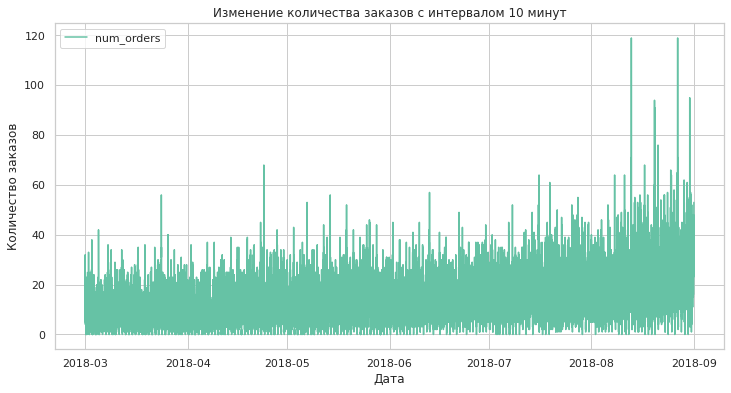

In [14]:
plot_line(df)
plt.title('Изменение количества заказов c интервалом 10 минут');

Выполним ресэмплирование по одному часу

In [15]:
df = df.resample('1H').sum()

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


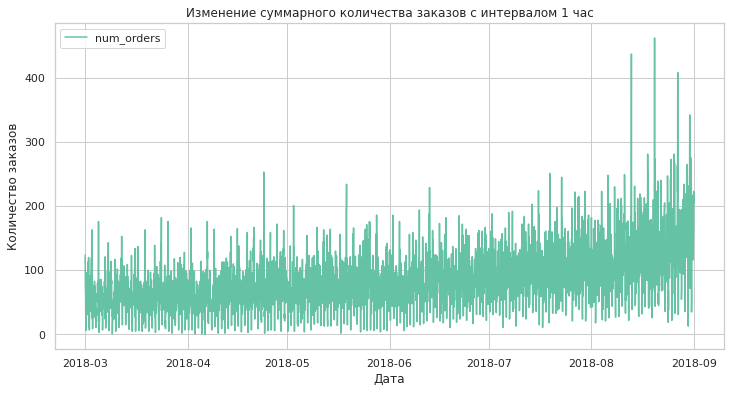

In [17]:
plot_line(df)
plt.title('Изменение суммарного количества заказов с интервалом 1 час');

### Промежуточный вывод

1. В нашем распоряжении датафрейм содержащий информацию количестве заказов такси с интервалом за час с 1 марта по 31 августа 2018 года.
2. Всего имеется 26496 строк
3. Мы изменили интервал временного ряда с 10 минут на 1 час, в результате у нас осталось 4416 строк
4. Записи расположены в хронологическом порядке с неизменным интервалом

## Анализ

### Декомпозиция

In [18]:
decomposed = seasonal_decompose(df['num_orders'])

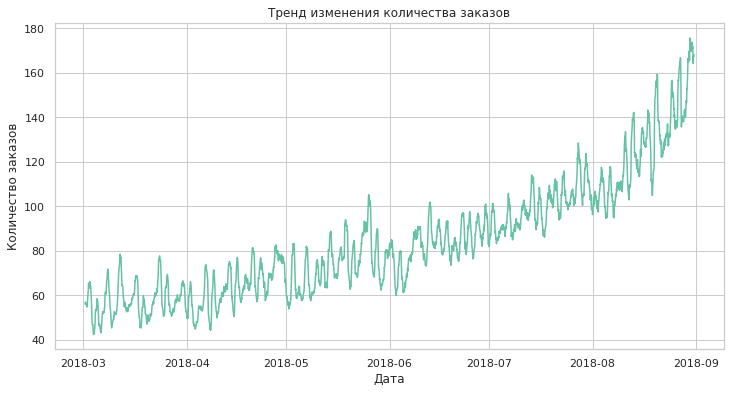

In [19]:
plot_line(decomposed.trend)
plt.title('Тренд изменения количества заказов')
plt.show();

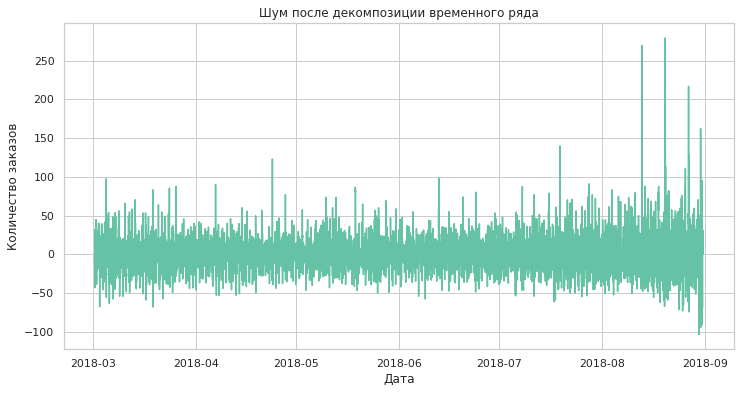

In [20]:
plot_line(decomposed.resid)
plt.title('Шум после декомпозиции временного ряда');

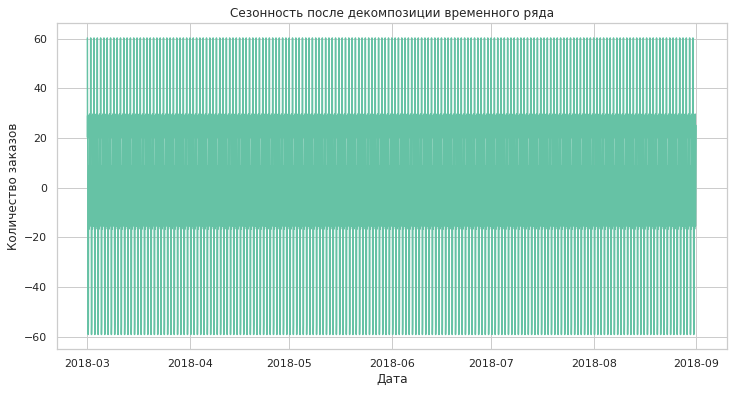

In [21]:
plot_line(decomposed.seasonal)
plt.title('Сезонность после декомпозиции временного ряда');

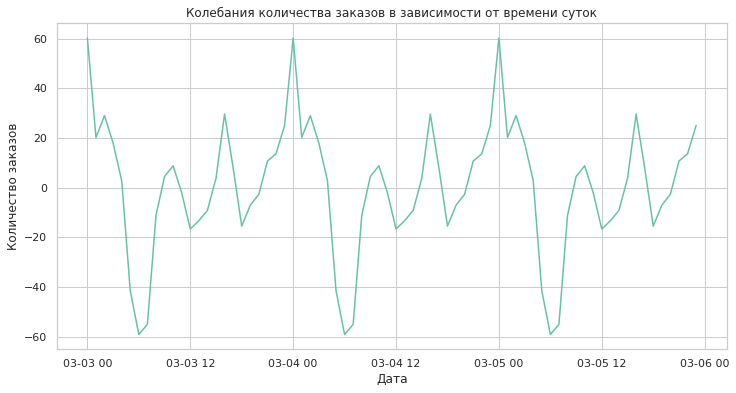

In [22]:
plot_line(decomposed.seasonal['2018-03-03' : '2018-03-05'])
plt.title('Колебания количества заказов в зависимости от времени суток');

In [23]:
decomposed = seasonal_decompose(df['num_orders'].resample('1D').sum())

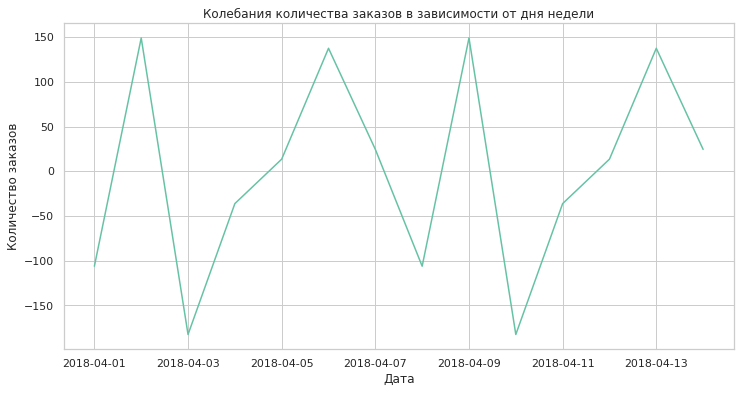

In [24]:
plot_line(decomposed.seasonal['2018-04-01':'2018-04-14'])
plt.title('Колебания количества заказов в зависимости от дня недели');

1. Явно виден тренд на увеличение количества заказов
2. Так как у нас данные только за полгода, сезонность связанная с временем года не наблюдается, однако, имеются суточные и недельные паттерны.

### Стационарность

In [25]:
df['std'] = df['num_orders'].rolling(15).std()
df['mean'] = df['num_orders'].rolling(15).mean()

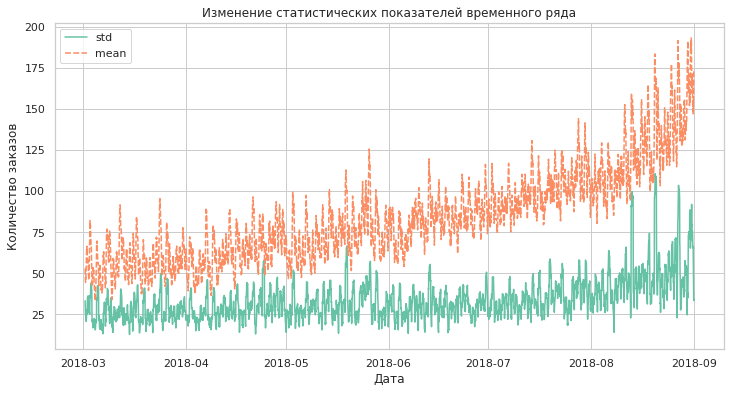

In [26]:
plot_line(df[['std', 'mean']])
plt.title('Изменение статистических показателей временного ряда');

In [27]:
df.drop(['std', 'mean'], axis=1, inplace=True)

По графику видно, что временной ряд не является стационарным, так как у него меняется среднее и стандартное отклонение. 

Дополнительно воспользуемся расширенным тестом Дики-Фуллера для проверки ряда на стационарность
- H0 Временной ряд является нестационарным
- H1 временной ряд является стационарным
- p-value = 0.05

In [28]:
def adf(df):
    if adfuller(df)[1] < 0.05:
        print('Отвергаем нулевую гипотезу, временной ряд является стационарным')
    else:
        print('Нулевую гипотезу отвергнуть не удалось, временный ряд нестационарный')

In [29]:
adf(df)

Отвергаем нулевую гипотезу, временной ряд является стационарным


Результаты теста Дики-Фуллера указывают на стационарность ряда, однако, визуальный анализ графиков среднего, стандартного отклонения и тренда после декомпозиции говорят об обратном. Проблему нестационарности мы решим созданием новых признаков с использованием, в том числе, скользящего среднего.

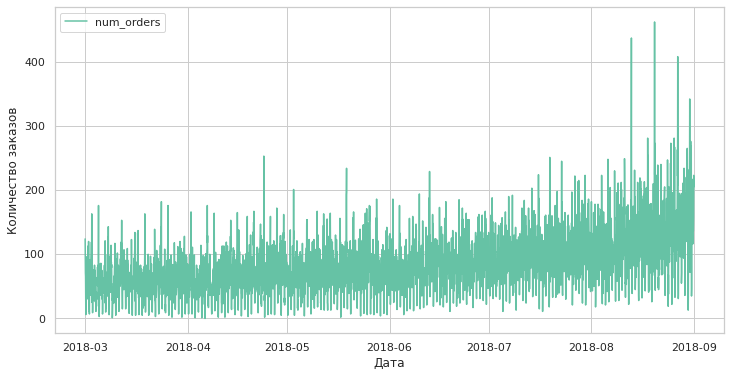

In [30]:
plot_line(df)

### Создадим новые признаки

Напишем функцию для создания доп. признаков, таких как:
   - Месяц, день, час, день недели, выходной ли и время дня и закодируем их средним значеним для каждой группы по скользящему среднему
   - Отстающие значения
   - Скользящее среднее
   
Оптимальные значения max_lag и rolling_mean_size будем подбирать наравне с гиперпараметрами

In [31]:
def code_mean(df, cat_feature, real_feature):

    return dict(df.groupby(cat_feature)[real_feature].mean())

In [32]:
def prepare_df(df, max_lag=0, rolling_mean_size=1, test_size=0.1, split=True):
    
    df_copy = df.copy()
    test_index = int(len(df) * (1 - test_size))
    
    #df_copy['month'] = df_copy.index.month
    #df_copy['day'] = df_copy.index.day
    df_copy['hour'] = df_copy.index.hour
    df_copy['day_of_week'] = df_copy.index.dayofweek
    df_copy['is_weekend'] = df_copy['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
    df_copy['time_of_day'] = pd.cut(df_copy.index.hour,
                               bins=[0, 6, 12, 18, 24],
                               labels=[0, 1, 2, 3],
                               include_lowest=True)
    
    
    if max_lag != 0:
        for lag in range(1, max_lag + 1):
            df_copy[f'lag_{lag}'] = df_copy['num_orders'].shift(lag)
    
    
    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
        
    df_copy['hour_mean'] = df_copy['hour'].map(df_copy[:test_index].groupby('hour')['rolling_mean'].mean())
    df_copy['day_of_week_mean'] = df_copy['day_of_week'].map(
        df_copy[:test_index].groupby('day_of_week')['rolling_mean'].mean())
    df_copy['is_weekend_mean'] = df_copy['is_weekend'].map(
        df_copy[:test_index].groupby('is_weekend')['rolling_mean'].mean())
    df_copy['time_of_day_mean'] = df_copy['time_of_day'].map(
        df_copy[:test_index].groupby('time_of_day')['rolling_mean'].mean())
        
    df_copy = df_copy.drop(['hour', 'day_of_week', 'is_weekend', 'time_of_day'], axis=1)
        
    df_copy = df_copy.dropna()
    
    train = df_copy.iloc[:test_index]
    test = df_copy.iloc[test_index:]
    
    if split == True:
        
        X_train = train.drop('num_orders', axis=1)
        X_test = test.drop('num_orders', axis=1)
        y_train = train['num_orders']
        y_test = test['num_orders']
    
        return X_train, X_test, y_train, y_test
    else:
        return train, test

## Обучение

### Тестирование моделей

Подберем оптимальные значения max_lag и rolling_mean_size а также оптимальные гиперпараметры с помощью фреймворка optuna.
Протестируем следующие модели:
- KNN-Regressor
- RandomForest
- LightGBM

### KNN-Regressor

In [33]:
def objective_knn(trial):
    
    max_lag = trial.suggest_int('max_lag', 1, 30)
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 1, 30)
    
    X_train, X_test, y_train, y_test = prepare_df(df, max_lag, rolling_mean_size)
    
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),  
    }
    
    
    model = KNeighborsRegressor(**params)
    
    tscv = TimeSeriesSplit(n_splits=3)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    
    
    rmse_mean = -cv_scores.mean()
    
    return rmse_mean

In [34]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_knn, n_trials=15, show_progress_bar=False)

[I 2023-11-20 16:02:06,042] A new study created in memory with name: no-name-0a5e3a6e-77f5-4cd3-b43e-16ea98c27bf4
[I 2023-11-20 16:02:06,482] Trial 0 finished with value: 31.189652231333014 and parameters: {'max_lag': 12, 'rolling_mean_size': 16, 'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 31.189652231333014.
[I 2023-11-20 16:02:06,563] Trial 1 finished with value: 31.438715614957868 and parameters: {'max_lag': 14, 'rolling_mean_size': 13, 'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 31.189652231333014.
[I 2023-11-20 16:02:06,655] Trial 2 finished with value: 31.938900068597366 and parameters: {'max_lag': 2, 'rolling_mean_size': 14, 'n_neighbors': 23, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 31.189652231333014.
[I 2023-11-20 16:02:06,742] Trial 3 finished with value: 34.12973496064771 and parameters: {'max_lag': 3, 'rolling_mean_size': 23, 'n_neighbors': 28, 'weights': 'distance', 'p': 2}. Best is trial

In [35]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'max_lag': 26, 'rolling_mean_size': 5, 'n_neighbors': 27, 'weights': 'uniform', 'p': 1}
Лучшее RMSE: 28.53848650085864


In [37]:
knn_params = study.best_params

### RandomForest

In [37]:
def objective_random_forest(trial):
    max_lag = trial.suggest_int('max_lag', 1, 30)
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 1, 30)
    
    X_train, X_test, y_train, y_test = prepare_df(df, max_lag, rolling_mean_size)
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
    }
    
    model = RandomForestRegressor(**params, random_state=1)
    
    tscv = TimeSeriesSplit(n_splits=3)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    
    #rmse_mean = np.sqrt(-cv_scores.mean())
    rmse_mean = -cv_scores.mean()
    return rmse_mean

In [38]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_random_forest, n_trials=10, show_progress_bar=False)

[I 2023-11-20 11:01:52,996] A new study created in memory with name: no-name-aaae303a-bea9-4efb-8ed0-8debee8000d8
/tmp/ipykernel_975/2289832436.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_copy[:test_index].groupby('time_of_day')['rolling_mean'].mean())
[I 2023-11-20 11:01:55,528] Trial 0 finished with value: 31.748630222604607 and parameters: {'max_lag': 19, 'rolling_mean_size': 5, 'n_estimators': 228, 'max_depth': 35, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.17807291057001295}. Best is trial 0 with value: 31.748630222604607.
/tmp/ipykernel_975/2289832436.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

In [39]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'max_lag': 27, 'rolling_mean_size': 9, 'n_estimators': 161, 'max_depth': 99, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 0.4772017614434081}
Лучшее RMSE: 27.88935778820169


In [40]:
rf_params = study.best_params

### LightGBM

In [57]:
def objective_lightgbm(trial):
    
    max_lag = trial.suggest_int('max_lag', 1, 20)
    rolling_mean_size = trial.suggest_int('rolling_mean_size', 1, 20)
    
    X_train, X_test, y_train, y_test = prepare_df(df, max_lag, rolling_mean_size)
    
    
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    }
    
    model = lgb.LGBMRegressor(**params, verbose=0)
    
    tscv = TimeSeriesSplit(n_splits=3)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    
    
    rmse_mean = -cv_scores.mean()
    
    return rmse_mean

In [58]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lightgbm, n_trials=10, show_progress_bar=False)

[I 2023-11-20 11:07:49,940] A new study created in memory with name: no-name-97d389be-0999-488c-a967-cd94064db349


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-11-20 11:07:54,261] Trial 0 finished with value: 43.392607006428456 and parameters: {'max_lag': 9, 'rolling_mean_size': 13, 'num_leaves': 52, 'learning_rate': 0.025236619697230327, 'min_child_samples': 29, 'boosting_type': 'dart'}. Best is trial 0 with value: 43.392607006428456.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2023-11-20 11:07:56,563] Trial 1 finished with value: 31.90263483880128 and parameters: {'max_lag': 11, 'rolling_mean_size': 14, 'num_leaves': 26, 'learning_rate': 0.010110303633835194, 'min_child_samples': 12, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 31.90263483880128.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-11-20 11:08:02,061] Trial 2 finished with value: 31.877804404188822 and parameters: {'max_lag': 9, 'rolling_mean_size': 20, 'num_leaves': 60, 'learning_rate': 0.0878227800419287, 'min_child_samples': 20, 'boosting_type': 'dart'}. Best is trial 2 with value: 31.877804404188822.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2023-11-20 11:08:06,761] Trial 3 finished with value: 27.359692918153215 and parameters: {'max_lag': 18, 'rolling_mean_size': 6, 'num_leaves': 46, 'learning_rate': 0.0350759666206076, 'min_child_samples': 5, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 27.359692918153215.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-11-20 11:08:09,872] Trial 4 finished with value: 49.213782366223036 and parameters: {'max_lag': 13, 'rolling_mean_size': 10, 'num_leaves': 32, 'learning_rate': 0.015597417522132229, 'min_child_samples': 46, 'boosting_type': 'dart'}. Best is trial 3 with value: 27.359692918153215.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2023-11-20 11:08:12,460] Trial 5 finished with value: 44.93318712435086 and parameters: {'max_lag': 11, 'rolling_mean_size': 12, 'num_leaves': 20, 'learning_rate': 0.023340354785128043, 'min_child_samples': 10, 'boosting_type': 'dart'}. Best is trial 3 with value: 27.359692918153215.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-11-20 11:08:15,868] Trial 6 finished with value: 26.87123593702533 and parameters: {'max_lag': 11, 'rolling_mean_size': 18, 'num_leaves': 46, 'learning_rate': 0.04276502980435798, 'min_child_samples': 24, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 26.87123593702533.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2023-11-20 11:08:17,361] Trial 7 finished with value: 27.37023818694824 and parameters: {'max_lag': 15, 'rolling_mean_size': 16, 'num_leaves': 12, 'learning_rate': 0.03926212605408229, 'min_child_samples': 32, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 26.87123593702533.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2023-11-20 11:08:18,765] Trial 8 finished with value: 52.37229472720836 and parameters: {'max_lag': 6, 'rolling_mean_size': 11, 'num_leaves': 9, 'learning_rate': 0.01260007422124426, 'min_child_samples': 33, 'boosting_type': 'dart'}. Best is trial 6 with value: 26.87123593702533.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2023-11-20 11:08:20,163] Trial 9 finished with value: 28.290020643490113 and parameters: {'max_lag': 7, 'rolling_mean_size': 7, 'num_leaves': 13, 'learning_rate': 0.03310062407360723, 'min_child_samples': 21, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 26.87123593702533.


In [59]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'max_lag': 11, 'rolling_mean_size': 18, 'num_leaves': 46, 'learning_rate': 0.04276502980435798, 'min_child_samples': 24, 'boosting_type': 'gbdt'}
Лучшее RMSE: 26.87123593702533


In [60]:
lgbm_params = study.best_params

In [61]:
lgbm_params = {k: lgbm_params[k] for k in lgbm_params if k not in ['max_lag', 'rolling_mean_size']}

У всех моделей разница оказалась незначительной, лучший результат показала модель LightGBM с результатом RMSE 26.978

## Тестирование

In [62]:
X_train, X_test, y_train, y_test = prepare_df(df, 11, 18)

In [63]:
model = lgb.LGBMRegressor(**lgbm_params)

In [64]:
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.04276502980435798, min_child_samples=24,
              num_leaves=46)

In [65]:
y_pred = model.predict(X_test)

In [66]:
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred))

In [67]:
constant_pred = y_test.shift(fill_value=y_train[-1])

/tmp/ipykernel_975/3773023409.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  constant_pred = y_test.shift(fill_value=y_train[-1])


In [68]:
rmse_const = np.sqrt(mean_squared_error(y_test, constant_pred))

In [69]:
print(f'Результаты на тестовой выборке для:\nLightGBM: {rmse_lgbm}\nКонстантной модели: {rmse_const}')

Результаты на тестовой выборке для:
LightGBM: 44.3371611920864
Константной модели: 58.88742457931834


## Вывод

1. В начале проекта мы загрузили данные о заказах такси в аэропортах за период с 1 марта по 31 августа 2018 года. Данные содержат информацию о количестве заказов с интервалом в 10 минут. Далее мы провели ресемплирование данных по одному часу, чтобы уменьшить шум и сделать временной ряд более устойчивым. В результате получили 4416 строк данных.
2. Для улучшения предсказательной способности моделей мы создали новые признаки:
 - Месяц, день, час, день недели, выходной ли день и время суток.
 - День недели, выходной, время суток и час мы заакодированное средним значением для каждой группы по скользящему среднему
 - Отстающие значения (lag) с максимальным лагом max_lag
 - Скользящее среднее с окном размера rolling_mean_size
 
3. Далее мы приступили к обучению различных моделей с использованием библиотеки optuna для оптимизации гиперпараметров и параметров функции - max_lag и rolling_mean_size. Протестировали следующие модели:

  - KNN-Regressor
  - RandomForest
  - LightGBM
Лучшие результаты показала LightGBM - 26.978.

4. Мы использовали лучшие гиперпараметры для модели и параметры для функции и протестировали модель на тестовой выборке. У LightGBM результат получился 42.9, у константной модели, предсказывающей медианным значеним обучающей выборки - 87.5. 

4. Во время проекта мы разработали эффективную модель для прогнозирования количества заказов такси на следующий час. Мы провели предварительный анализ данных, создали новые признаки, и успешно обучили и протестировали несколько моделей машинного обучения. В результате LightGBM показал наилучшие результаты, что подтверждает его эффективность для задачи временных рядов.